In [1]:
import numpy
from matplotlib import pyplot
from pandas import read_csv
import math
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline

# load the dataset
dataframe = read_csv('intecleaned-correct.csv',usecols=[1,2,4,5,6,7,8,9])
dataset = dataframe.values
#将整型变为float
dataset = dataset.astype('float32')

# fix random seed for reproducibility
numpy.random.seed(7)
# normalize the dataset
scaler_y = MinMaxScaler(feature_range=(0, 1))#功率数据归一化，之后还原预测结果要用
Y = scaler_y.fit_transform(dataset[:,5:6])

scaler_y1 = MinMaxScaler(feature_range=(0, 1))#风速数据归一化
Y1 = scaler_y1.fit_transform(dataset[:,6:7])

scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

dataset.shape

(43584, 8)

In [2]:
dataframe.head()

,短期预测功率,短期预测湿度,短期预测风向,短期预测温度,短期预测气压,实际功率,实际风速,短期预测风速
0,34.41,75,41,14.7,1008,28.59,8.50,8.864167
1,33.71,75,40,14.7,1008,29.80,8.75,8.764167
2,33.01,75,39,14.6,1008,23.80,7.78,8.664167
3,32.32,75,38,14.5,1008,23.63,7.89,8.564167
4,31.66,75,38,14.5,1008,26.98,7.69,8.464167


In [3]:
datasetCopy = numpy.hstack([dataset[:,1:5],dataset[:,7:8]])
datasetCopy.shape

(43584, 5)

In [4]:
!pip install keras==2.2.4

Looking in indexes: http://mirrors.tencentyun.com/pypi/simple


In [5]:
import keras
from keras.layers import Dense, Input
from keras.models import Model

Using TensorFlow backend.


In [6]:
input = Input(shape=(5,))
encoded = Dense(128, activation='relu')(input)
encoded1 = Dense(64, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded1)
decoded1 = Dense(5, activation='tanh')(decoded)
autoencoder = Model(input=input, output=decoded1)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.fit(datasetCopy, datasetCopy, epochs=20, batch_size=128, verbose=1)

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:6: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`



Epoch 1/20





43584/43584 [==============================] - 3s 62us/step - loss: 0.0180
Epoch 2/20
43584/43584 [==============================] - 1s 19us/step - loss: 2.9596e-04
Epoch 3/20
43584/43584 [==============================] - 1s 19us/step - loss: 1.6459e-04
Epoch 4/20
43584/43584 [==============================] - 1s 19us/step - loss: 1.1752e-04
Epoch 5/20
43584/43584 [==============================] - 1s 19us/step - loss: 9.1355e-05
Epoch 6/20
43584/43584 [==============================] - 1s 19us/step - loss: 7.3665e-05
Epoch 7/20
43584/43584 [==============================] - 1s 20us/step - loss: 5.8809e-05
Epoch 8/20
43584/43584 [==============================] - 1s 19us/step - loss: 4.8846e-05
Epoch 9/20
43584/43584 [==============================] - 1s 19us/step - loss: 4.1852e-05
Epoch 10/20
43584/43584 [==============================] - 1s 19us/step - loss: 3.6374e-05
Epoch 11/20
43584/43584 [==============================] - 1s 19us/step - loss: 3.1744e-05
Epoch 

In [7]:
encoderModel = Model(input=input, output=encoded1)
encoded_input = Input(shape=(64,))  
decoder_layer = autoencoder.layers[-1]  
decoderModel = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))
encoded_data = encoderModel.predict(datasetCopy)  
datasetCopy = decoderModel.predict(encoded_data)
#trainnewX = autoencoder.predict(train_X)

/opt/conda/envs/tensorflow_py3/lib/python3.6/site-packages/ipykernel/__main__.py:1: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  if __name__ == '__main__':


In [8]:
datasetCopy.shape

(43584, 5)

In [9]:
def create_dataset(dataset,dataset1, look_back,look_lag,data_step):
    main_dataX, main_dataY ,auxi_dataX,auxi_dataY= [], [],[],[]
    for i in range(0,len(dataset)-look_back-look_lag+1,data_step):
        a = dataset[i:(i+look_back), :] #5个
        c = dataset[(i+look_back):(i+look_back+look_lag),:]#5个
        d = dataset1[i:(i+look_back),5:7]#2个
        e = numpy.hstack([a,c])
        e = numpy.hstack([d,e])#把上面的特征都合在一起，共12个特征
        main_dataX.append(e) #主要输入
        b = dataset1[(i+look_back):(i+look_back+look_lag),5]
        main_dataY.append(b) #主要输出 需要预测的功率数据
    return numpy.array(main_dataX), numpy.array(main_dataY)#,numpy.array(auxi_dataX),numpy.array(auxi_dataY)


look_back = 16
look_lag = 16
train_size = 364*96
test_size = len(dataset) - train_size
train, test = datasetCopy[0:train_size,:], datasetCopy[train_size-look_back:len(dataset),:]
train1, test1 = dataset[0:train_size,:], dataset[train_size-look_back:len(dataset),:]
train_mainX, train_mainY = create_dataset(train, train1,look_back,look_lag,4)#,train_auxiX,train_auxiY
test_mainX, test_mainY = create_dataset(test, test1,look_back,look_lag,16)#,test_auxiX,test_auxiY

# reshape input to be [samples, time steps, features]
train_mainX = numpy.reshape(train_mainX, (train_mainX.shape[0], look_back, 12))

test_mainX = numpy.reshape(test_mainX, (test_mainX.shape[0], look_back, 12))

In [10]:
import keras
from keras.models import Model
from keras.layers import Dense,Input,Masking
from keras.layers import LSTM,Conv1D,MaxPooling1D
from keras.layers import Dropout
from keras.layers import Activation,concatenate
from keras.utils import to_categorical
from keras.models import load_model
from keras.engine import Layer
import keras.backend as K
from keras.layers import Multiply
from keras.layers.core import *
from keras.layers.recurrent import LSTM
from keras.models import *
from keras.regularizers import l2
#输入层
main_input = Input(shape=(train_mainX.shape[1],train_mainX.shape[2]))
#auxi_input = Input(shape=(train_auxiX.shape[1],train_auxiX.shape[2]))
#模型1#
#三层卷积层
convolution1 = Conv1D(8, kernel_size=5, strides=1, activation='relu', padding='same')(main_input)
Pool1 = MaxPooling1D(pool_size=3)(convolution1)
convolution2 = Conv1D(8, kernel_size=5, strides=1, activation='relu', padding='same')(Pool1)
Pool2 = MaxPooling1D(pool_size=3)(convolution2)
#convolution3 = Conv1D(8, kernel_size=3, strides=1, activation='relu', padding='same')(convolution2)
Flat = Flatten()(Pool2)
Drop2 = Dropout(0.5)(Flat)

#模型2
#两层LSTM
LSTM1 = LSTM(units=96, return_sequences=True)(main_input) 
#Drop3 = Dropout(0.2)(LSTM1)
LSTM2 = LSTM(units=48, return_sequences=False)(LSTM1)
Drop1 = Dropout(0.5)(LSTM2)
#LSTM3 = LSTM(units=48, return_sequences=False)(LSTM2)
#attention_mul = attention_3d_block(LSTM2)

#模型1和模型2连接起来
con = concatenate([Drop2,Drop1])
#Flat = Flatten()(con)
main_output = Dense(units = look_lag)(con)#主要输出
#main_output = Dropout(0.2)(main_output)

model = Model(inputs=main_input, outputs=main_output)
model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history = model.fit(train_mainX,train_mainY, validation_split=0.33,epochs=100, batch_size=120, shuffle=True)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 5848 samples, validate on 2881 samples
Epoch 1/100
5848/5848 [==============================] - 8s 1ms/step - loss: 0.0623 - val_loss: 0.0216
Epoch 2/100
5848/5848 [==============================] - 3s 459us/step - loss: 0.0271 - val_loss: 0.0174
Epoch 3/100
5848/5848 [==============================] - 3s 456us/step - loss: 0.0225 - val_loss: 0.0150
Epoch 4/100
5848/5848 [==============================] - 3s 456us/step - loss: 0.0202 - val_loss: 0.0141
Epoch 5/100
5848/5848 [==============================] - 3s 457us/step - loss: 0.0191 - val_loss: 0.0168
Epoch 6/100
5848/5848 [==============================] - 3s 456us/step - loss: 0.0175 - val_loss: 0.0128
Epoch 7/100
5848/5848 [==============================] - 3s 464us/step - loss: 0.0165 - val_loss: 0.0125
Epoch 8/

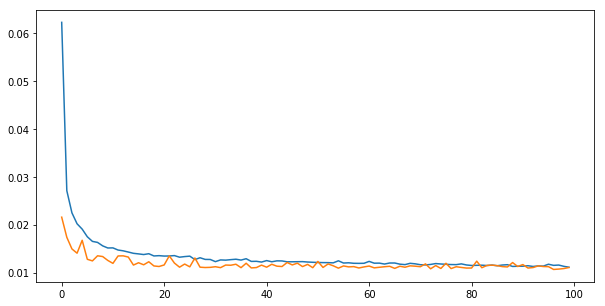

In [11]:
pyplot.figure(figsize=(10,5))
pyplot.plot(history.history['loss'], label='loss')
pyplot.plot(history.history['val_loss'], label='val_loss')

In [12]:
testPredict = model.predict(test_mainX)

In [13]:
testPredict = testPredict.reshape(-1,1)
testPredict = scaler_y.inverse_transform(testPredict)
testPredict

array([[30.899076],
       [31.113298],
       [30.354488],
       ...,
       [34.850147],
       [34.602688],
       [34.117344]], dtype=float32)

In [14]:
testPredict.shape

(8640, 1)

In [15]:
test_mainY = test_mainY.reshape(-1,1)
test_mainY = scaler_y.inverse_transform(test_mainY)
test_mainY.shape

(8640, 1)

In [16]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score
def result(testY,testPredict):
    mse = mean_squared_error(testY,testPredict)
    mae = mean_absolute_error(testY,testPredict)
    r_square = r2_score(testY,testPredict)
    print("MSE:",mse)
    print("MAE:",mae)
    print("R_Square:",r_square)
    rmse = math.sqrt(mse)
    print("RMSE:",rmse)
    capacity = 49.5
    print("NRMSE:",1 - rmse/capacity)
    p_hme = 0
    whole_power = 49.5
    for l in range(testY.shape[0]):
        if testY[l] <= whole_power * 0.03 and testPredict[l] <= whole_power * 0.03:
            continue
        p_hme = p_hme + abs(testY[l] / (testY[l] + testPredict[l]) - 0.5) * abs(testPredict[l] -testY[l]) / np.sum(np.abs(testPredict - testY))
    p_hme =  1 - 2 * p_hme
    print('E', p_hme)

In [17]:
import numpy as np
predictions_1 = testPredict[0:31*96,0]
predictions_2 = testPredict[31*96:59*96,0]
predictions_3 = testPredict[59*96:90*96,0]

test_labels_1 = test_mainY[0:31*96,0]
test_labels_2 = test_mainY[31*96:59*96,0]
test_labels_3 = test_mainY[59*96:90*96,0]

print("2019年1-3月结果：")
result(test_mainY,testPredict)
print("2019年1月结果：")
result(test_labels_1,predictions_1)
print("2019年2月结果：")
result(test_labels_2,predictions_2)
print("2019年3月结果：")
result(test_labels_3,predictions_3)

2019年1-3月结果：
MSE: 26.642225
MAE: 3.6755517
R_Square: 0.8536901293438809
RMSE: 5.161610723941019
NRMSE: 0.8957250358799794
E [0.7075358]
2019年1月结果：
MSE: 28.903872
MAE: 3.9492047
R_Square: 0.8236074154432336
RMSE: 5.376232094716046
NRMSE: 0.8913892506117971
E 0.7433407676139516
2019年2月结果：
MSE: 25.930815
MAE: 3.5834775
R_Square: 0.8611526844789331
RMSE: 5.0922308218542085
NRMSE: 0.8971266500635513
E 0.7216415628211568
2019年3月结果：
MSE: 25.02315
MAE: 3.4850628
R_Square: 0.8656223225434045
RMSE: 5.002314413384713
NRMSE: 0.8989431431639452
E 0.6538609573620011


In [21]:
#原系统准确率
testorin=dataframe.values[train_size:,0]
testorin=testorin.reshape(8640,1)
systempredictions_1 = testorin[0:31*96,0]
systempredictions_2 = testorin[31*96:59*96,0]
systempredictions_3 = testorin[59*96:90*96,0]
#原始系统准确率
print("原始系统准确率:")
print("2019年1-3月结果：")
result(test_mainY,testorin)
print("2019年1月结果：")
result(test_labels_1,systempredictions_1)
print("2019年2月结果：")
result(test_labels_2,systempredictions_2)
print("2019年3月结果：")
result(test_labels_3,systempredictions_3)

原始系统准确率:
2019年1-3月结果：
MSE: 38.90323077467954
MAE: 4.73843288221362
R_Square: 0.7863569507222773
RMSE: 6.237245447685985
NRMSE: 0.8739950414608892
E [0.66917906]
2019年1月结果：
MSE: 38.48454371279563
MAE: 4.870769504471107
R_Square: 0.7651391491589099
RMSE: 6.203591194847999
NRMSE: 0.8746749253566061
E 0.7053141024294813
2019年2月结果：
MSE: 43.47097008356602
MAE: 5.008162211467779
R_Square: 0.7672333948800686
RMSE: 6.593251859558076
NRMSE: 0.8668029927362004
E 0.6714997321255596
2019年3月结果：
MSE: 35.19621781563373
MAE: 4.3624697690168945
R_Square: 0.8109915717941774
RMSE: 5.932640037591504
NRMSE: 0.8801486861092626
E 0.6264273692486862


In [22]:
new_data = numpy.hstack([test_mainY,testorin,testPredict])
import pandas as pd
new_data = pd.DataFrame(new_data,columns= ['实际功率','原系统预测功率','超短期预测功率'])
new_data.to_csv('AE_lstm-ushort-89.78.csv', index=False, sep=',')